In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import optimize
from scipy import integrate
from sklearn.linear_model import LinearRegression as lr

In [14]:
def readfile_cal(data_filename):
    with open(data_filename ,"r") as f:
        for x,line in enumerate(f):
            if 'Channel Data:' in line: 
                data_start = x+2
                print("Data starts on row {}".format(data_start))
                break

    data = np.loadtxt( data_filename , unpack=True, skiprows = data_start,delimiter= "\t")#,usecols=[0,2]) #numpy opens the data starting at the appropriate place
    # Change the delimiter to "," if you have a .csv file

    channel = data[0]
    if(len(data)==2): # If you didn't calibrate the energies, the second row contains the particle counts
        N = data[1]
    else:
        Energy = data[1]
        N = data[2]

    dN = np.sqrt(N)
    for i, value in enumerate(dN):
        if value == 0:
            dN[i] = 1.14
    return(channel, N, dN, Energy)

def readfile(data_filename):
    with open(data_filename ,"r") as f:
        for x,line in enumerate(f):
            if 'Channel Data:' in line: 
                data_start = x+2
                print("Data starts on row {}".format(data_start))
                break

    data = np.loadtxt( data_filename , unpack=True, skiprows = data_start,delimiter= "\t",usecols=[0,2]) #numpy opens the data starting at the appropriate place
    # Change the delimiter to "," if you have a .csv file

    channel = data[0]
    if(len(data)==2): # If you didn't calibrate the energies, the second row contains the particle counts
        N = data[1]
    else:
        Energy = data[1]
        N = data[2]

    dN = np.sqrt(N)
    for i, value in enumerate(dN):
        if value == 0:
            dN[i] = 1.14

    datafinal=[]
    datafinal.append(channel)
    datafinal.append(N)
    datafinal.append(dN)
    return(datafinal)

def gaussianfunc(p,x):
    return p[0]/(p[2]*np.sqrt(2*np.pi))*np.exp(-(x-p[1])**2/(2*p[2]**2))

def linearfunc(p,x):
    return p[0]*x + p[1]

def gaussianlinear(p,x):
    return gaussianfunc(p[0:3],x) + linearfunc(p[3:5],x)

def residual(p,func, xvar, yvar, err):
    return (func(p, xvar) - yvar)/err

def data_fit(p0, func, xvar, yvar, err, tmi=0):
    try:
        fit = optimize.least_squares(residual, p0, args=(func,xvar, yvar, err), verbose=tmi)
    except Exception as error:
        print("Something has gone wrong:",error)
        return p0, np.zeros_like(p0), np.nan, np.nan
    pf = fit['x']

    print()

    try:
        cov = np.linalg.inv(fit['jac'].T.dot(fit['jac']))          
        # This computes a covariance matrix by finding the inverse of the Jacobian times its transpose
        # We need this to find the uncertainty in our fit parameters
    except:
        # If the fit failed, print the reason
        print('Fit did not converge')
        print('Result is likely a local minimum')
        print('Try changing initial values')
        print('Status code:', fit['status'])
        print(fit['message'])
        return pf, np.zeros_like(pf), np.nan, np.nan
            #You'll be able to plot with this, but it will not be a good fit.

    chisq = sum(residual(pf, func, xvar, yvar, err) **2)
    dof = len(xvar) - len(pf)
    red_chisq = chisq/dof
    pferr = np.sqrt(np.diagonal(cov)) # finds the uncertainty in fit parameters by squaring diagonal elements of the covariance matrix
    print('Converged with chi-squared {:.2f}'.format(chisq))
    print('Number of degrees of freedom, dof = {:.2f}'.format(dof))
    print('Reduced chi-squared {:.2f}'.format(red_chisq))
    print()
    Columns = ["Parameter #","Initial guess values:", "Best fit values:", "Uncertainties in the best fit values:"]
    print('{:<11}'.format(Columns[0]),'|','{:<24}'.format(Columns[1]),"|",'{:<24}'.format(Columns[2]),"|",'{:<24}'.format(Columns[3]))
    for num in range(len(pf)):
        print('{:<11}'.format(num),'|','{:<24.3e}'.format(p0[num]),'|','{:<24.3e}'.format(pf[num]),'|','{:<24.3e}'.format(pferr[num]))
    return pf, pferr, chisq, dof

Data starts on row 25


Text(0.5, 1.0, 'Direct Spectrum (25kV, 20$\\mu$A) with Rough Calibration')

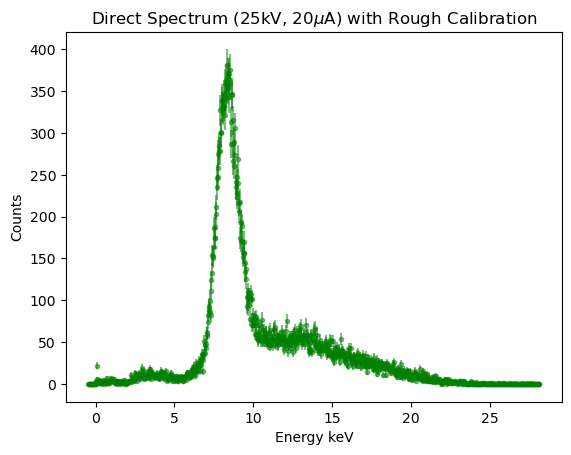

In [5]:
channel_1, N_1, dN_1, Energy_1= readfile_cal("Calibrated/25kV,10muA.tsv")
fig,ax = plt.subplots()
ax.errorbar(Energy_1, N_1, dN_1, fmt='g.',alpha = 0.5,label='Data')
plt.xlabel('Energy keV')
plt.ylabel('Counts')
plt.title('Direct Spectrum (25kV, 20$\mu$A) with Rough Calibration')

In [121]:
#Bragg Scattering
#Sample PHA Spectrum
eleven=readfile("11.tsv")
fig,ax = plt.subplots()
ax.errorbar(eleven[0], eleven[1], eleven[2], fmt='r.',alpha = 0.5,label='Data')
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.title('Co57 (25kV, 20$\mu$A)')

numpy.float64

Text(0.5, 1.0, 'Bragg Scattering (25kV, 20$\\mu$A)')

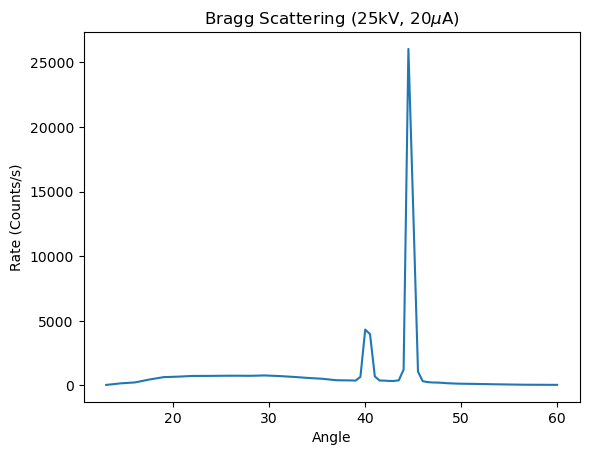

In [298]:
data = np.loadtxt("Rate_angle.txt" , unpack=True, skiprows = 1,delimiter= ";", usecols=[0,1,2])
rate=data[1]/data[2]
drate=np.sqrt(data[1])/data[2]

fig,ax = plt.subplots()
ax.plot(data[0], rate, alpha = 1,label='Data')
plt.xlabel('Angle')
plt.ylabel('Rate (Counts/s)')
plt.title('Bragg Scattering (25kV, 20$\mu$A)')

In [347]:
#h=4.135e-15
h=6.6261e-34
c=299792458 
d= 0.2008
dd= 0.0001
def en(x, n):
    l=(2*d*np.sin(np.deg2rad(x))*1e-9)/n
    #l in m
    E= (6.242e15*h*c)/(l)
    #in keV
    return(E)

def unce(val, ang, uncer):
    dy = val* np.sqrt((0.0001 / 0.2008)**2 + (uncer / ang)**2)
    return(dy)

en(13, 2)

27.45052858721246

In [346]:
h = 6.62607015e-34  # Planck's constant in J s
c = 299792458  # Speed of light in m/s
lambda_min = 4.9593679373280106e-11  # Wavelength in meters

# Calculate energy of the photon
E = h * c / lambda_min

# Convert energy to keV
E_keV = E / 1.602176634e-16  # Convert J to keV

print("Energy of the photon:", E_keV, "keV")

Energy of the photon: 25.0 keV


In [345]:
h = 6.62607015e-34  # Planck's constant in J s
c = 299792458  # Speed of light in m/s
e = 1.602176634e-19  # Elementary charge in C
V = 25e3  # Potential difference in volts (converted from kV to V)

# Calculate lambda_min
h * c / (e * V)


4.9593679373280106e-11

In [ ]:

To calculate the energy 
�
E of a photon in kiloelectronvolts (keV) corresponding to a given wavelength 
�
min
=
6.199209921660014
×
1
0
−
11
λ 
min
​
 =6.199209921660014×10 
−11
  meters, you can use the formula:

�
=
ℎ
�
�
E= 
λ
hc
​
 

Given:

�
min
=
6.199209921660014
×
1
0
−
11
λ 
min
​
 =6.199209921660014×10 
−11
  meters
ℎ
=
6.62607015
×
1
0
−
34
h=6.62607015×10 
−34
  J s (Planck's constant)
�
=
299792458
c=299792458 m/s (speed of light)
Let's perform the calculation:

python
Copy code
# Constants
h = 6.62607015e-34  # Planck's constant in J s
c = 299792458  # Speed of light in m/s
lambda_min = 6.199209921660014e-11  # Wavelength in meters

# Calculate energy of the photon
E = h * c / lambda_min

# Convert energy to keV
E_keV = E / 1.602176634e-16  # Convert J to keV

print("Energy of the photon:", E_keV, "keV")

In [348]:
unce(27, 13, 0.5)

1.038548587002785

In [315]:
np.sin(42.5)

-0.996086503119594

In [ ]:
np.sqrt((dy_dd * 0.0001)**2 + (dy_dx * 0.5)**2)

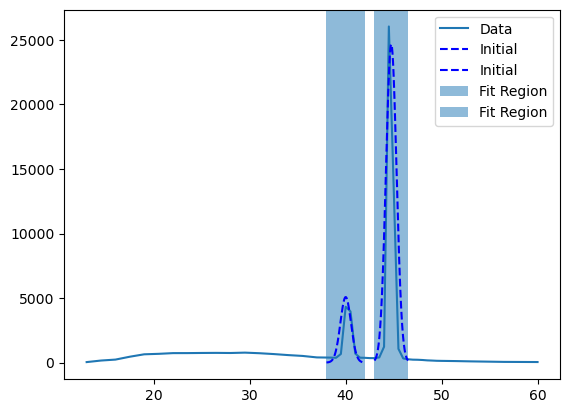

In [7]:
min_value = 38
max_value = 42
count_estimate = 7000
center_estimate = 40
width_estimate = 0.55
slope = 0
offset = 0
p02 = [count_estimate, center_estimate , width_estimate,slope,offset]


min_value_1 = 43
max_value_1 = 46.5
count_estimate = 34000
center_estimate = 44.75
width_estimate = 0.55
slope = 0
offset = 0
p03 = [count_estimate, center_estimate , width_estimate,slope,offset]


fig,ax = plt.subplots()
ax.plot(data[0], rate, alpha = 1,label='Data')
channel_cont = np.linspace(min_value, max_value , 5000)
ax.plot(channel_cont, gaussianlinear(p02, channel_cont), 'b--', label='Initial',zorder=10)

channel_cont_1 = np.linspace(min_value_1, max_value_1 , 5000)
ax.plot(channel_cont_1, gaussianlinear(p03, channel_cont_1), 'b--', label='Initial',zorder=10)
ax.axvspan(min_value_1 ,max_value_1,label='Fit Region',alpha = 0.5)
ax.axvspan(min_value ,max_value,label='Fit Region',alpha = 0.5)
ax.legend()

array([56.5, 53. , 51.5, 50. , 49.5])

Gaussian only

Fit did not converge
Result is likely a local minimum
Try changing initial values
Status code: 1
`gtol` termination condition is satisfied.


Gaussian with linear background

Fit did not converge
Result is likely a local minimum
Try changing initial values
Status code: 1
`gtol` termination condition is satisfied.


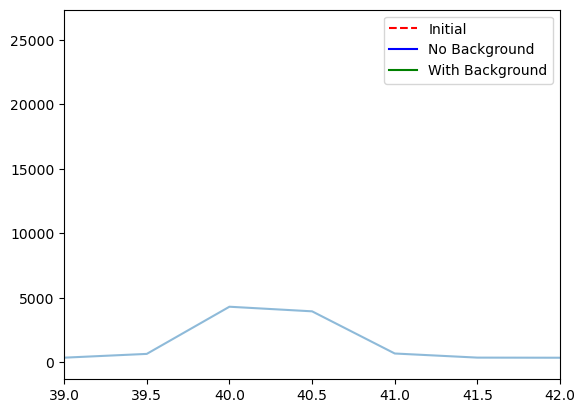

In [8]:
min_value = 39
max_value = 42
count_estimate = 7000
center_estimate = 40
width_estimate = 0.55
slope = 0
offset = 0
p02 = [count_estimate, center_estimate , width_estimate,slope,offset]


fig,ax = plt.subplots()
ax.plot(data[0], rate,alpha = 0.5)
ax.set_xlim(min_value,max_value)
channel2 = data[0][min_value:max_value]
N2 = rate[min_value:max_value]
dN2 = drate[min_value:max_value]

p0 = [count_estimate, center_estimate , width_estimate]
channel_cont = np.linspace(min(channel2), max(channel2), 5000)
ax.plot(channel_cont, gaussianfunc(p0, channel_cont), 'r--', label='Initial',zorder=10)

print("Gaussian only")
pf1, pferr1, chisq1, dof1 = data_fit(p0, gaussianfunc, channel2, N2, dN2)
ax.plot(channel_cont, gaussianfunc(pf1, channel_cont), 'b-', label='No Background',zorder=11)

print("\n\nGaussian with linear background")
p02 = [count_estimate, center_estimate , width_estimate,slope,offset]
pf2, pferr2, chisq2, dof2 = data_fit(p02, gaussianlinear, channel2, N2, dN2)
ax.plot(channel_cont, gaussianlinear(pf2, channel_cont), 'g-', label='With Background',zorder=11)

ax.legend()

Data starts on row 22


Text(0.5, 1.0, 'Co57 (25kV, 20$\\mu$A)')

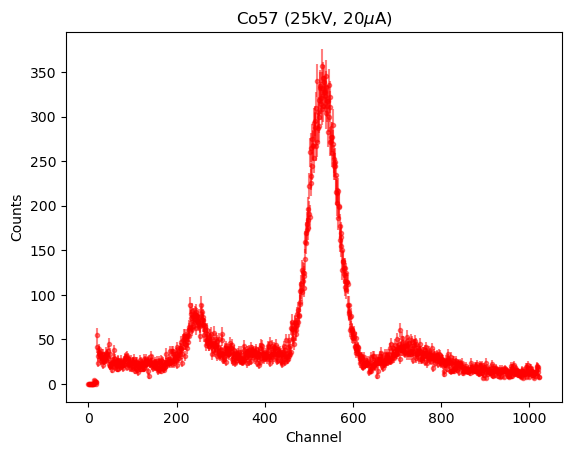

In [17]:
#Calibration
#Co-57

Calibration= readfile("Calibrated/Co57 Calibration.tsv")
fig,ax = plt.subplots()
ax.errorbar(Calibration[0], Calibration[1], Calibration[2], fmt='r.',alpha = 0.5,label='Data')
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.title('Co57 (25kV, 20$\mu$A)')

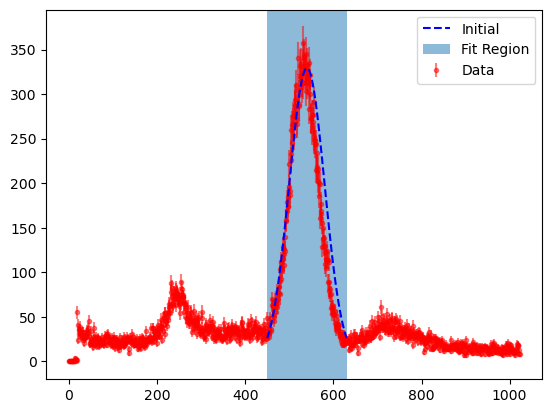

In [76]:
min_value = 450
max_value = 630
count_estimate = 33000
center_estimate = 540
width_estimate = 40
slope = 0
offset = 0
p02 = [count_estimate, center_estimate , width_estimate,slope,offset]


fig,ax = plt.subplots()
ax.errorbar(Calibration[0], Calibration[1], Calibration[2], fmt='r.',alpha = 0.5,label='Data')
channel_cont = np.linspace(min_value, max_value , 5000)
ax.plot(channel_cont, gaussianlinear(p02, channel_cont), 'b--', label='Initial',zorder=10)
ax.axvspan(min_value ,max_value,label='Fit Region',alpha = 0.5)
ax.legend()

Gaussian only

Converged with chi-squared 319.75
Number of degrees of freedom, dof = 177.00
Reduced chi-squared 1.81

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 3.300e+04                | 2.842e+04                | 1.703e+02               
1           | 5.400e+02                | 5.336e+02                | 2.256e-01               
2           | 4.000e+01                | 3.595e+01                | 1.946e-01               


Gaussian with linear background

Converged with chi-squared 181.41
Number of degrees of freedom, dof = 175.00
Reduced chi-squared 1.04

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 3.300e+04                | 2.464e+04                | 3.303e+02               
1           | 5.400e+02                | 5.336e+02                | 3.070e-01               
2           | 4.000e+01                | 3.184e+01                |

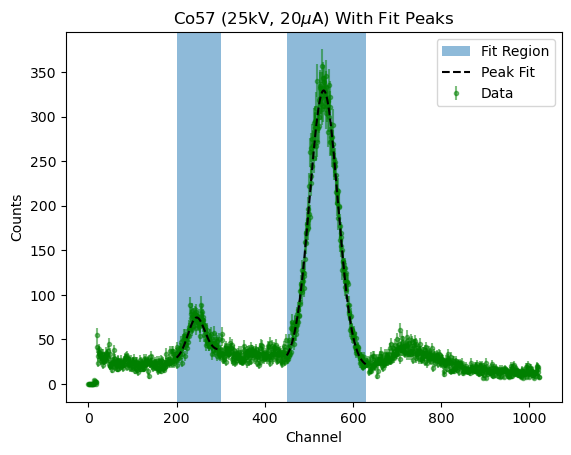

In [77]:
fig,ax = plt.subplots()
ax.errorbar(Calibration[0], Calibration[1], Calibration[2], fmt='g.',alpha = 0.5,label='Data')
#ax.set_xlim(min_value,max_value)

channel2 = Calibration[0][min_value:max_value]
N2 = Calibration[1][min_value:max_value]
dN2 = Calibration[2][min_value:max_value]

p0 = [count_estimate, center_estimate , width_estimate]
channel_cont = np.linspace(min(channel2), max(channel2), 5000)
#ax.plot(channel_cont, gaussianfunc(p0, channel_cont), 'r--', label='Initial',zorder=10)

print("Gaussian only")
pf1, pferr1, chisq1, dof1 = data_fit(p0, gaussianfunc, channel2, N2, dN2)
#ax.plot(channel_cont, gaussianfunc(pf1, channel_cont), 'b-', label='No Background',zorder=11)

print("\n\nGaussian with linear background")
p02 = [count_estimate, center_estimate , width_estimate,slope,offset]
pf2, pferr2, chisq2, dof2 = data_fit(p02, gaussianlinear, channel2, N2, dN2)
ax.axvspan(min_value ,max_value,label='Fit Region',alpha = 0.5)
ax.plot(channel_cont, gaussianlinear(pf2, channel_cont), 'k--', label='Peak Fit',zorder=11)
#plt.title('14.4keV Peak with Fit')


min_value = 200
max_value = 300
count_estimate = 3500
center_estimate = 250
width_estimate = 20
slope = 0
offset = 0
p02 = [count_estimate, center_estimate , width_estimate,slope,offset]

channel2 = Calibration[0][min_value:max_value]
N2 = Calibration[1][min_value:max_value]
dN2 = Calibration[2][min_value:max_value]

p0 = [count_estimate, center_estimate , width_estimate]
channel_cont = np.linspace(min(channel2), max(channel2), 5000)
#ax.plot(channel_cont, gaussianfunc(p0, channel_cont), 'r--', label='Initial',zorder=10)

print("Gaussian only")
pf1, pferr1, chisq1, dof1 = data_fit(p0, gaussianfunc, channel2, N2, dN2)
#ax.plot(channel_cont, gaussianfunc(pf1, channel_cont), 'b-', label='No Background',zorder=11)

print("\n\nGaussian with linear background")
p02 = [count_estimate, center_estimate , width_estimate,slope,offset]
pf2, pferr2, chisq2, dof2 = data_fit(p02, gaussianlinear, channel2, N2, dN2)
ax.axvspan(min_value ,max_value,alpha = 0.5)
ax.plot(channel_cont, gaussianlinear(pf2, channel_cont), 'k--', zorder=11)

plt.title('Co57 (25kV, 20$\mu$A) With Fit Peaks')


ax.set_xlabel("Channel")
ax.set_ylabel("Counts")
ax.legend()

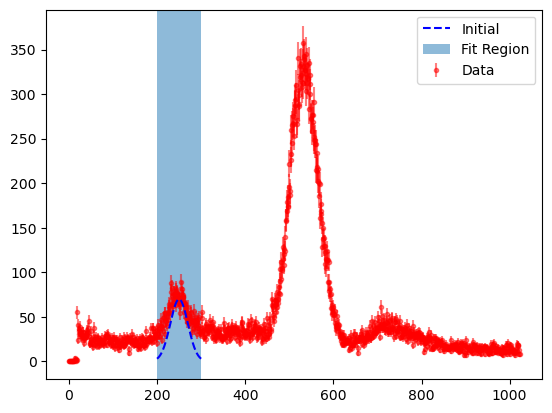

In [78]:
min_value = 200
max_value = 300
count_estimate = 3500
center_estimate = 250
width_estimate = 20
slope = 0
offset = 0
p02 = [count_estimate, center_estimate , width_estimate,slope,offset]


fig,ax = plt.subplots()
ax.errorbar(Calibration[0], Calibration[1], Calibration[2], fmt='r.',alpha = 0.5,label='Data')
channel_cont = np.linspace(min_value, max_value , 5000)
ax.plot(channel_cont, gaussianlinear(p02, channel_cont), 'b--', label='Initial',zorder=10)
ax.axvspan(min_value ,max_value,label='Fit Region',alpha = 0.5)
ax.legend()

Gaussian only

Converged with chi-squared 148.19
Number of degrees of freedom, dof = 97.00
Reduced chi-squared 1.53

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 3.500e+03                | 6.292e+03                | 1.282e+02               
1           | 2.500e+02                | 2.495e+02                | 7.341e-01               
2           | 2.000e+01                | 3.667e+01                | 1.056e+00               


Gaussian with linear background

Converged with chi-squared 111.75
Number of degrees of freedom, dof = 95.00
Reduced chi-squared 1.18

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 3.500e+03                | 2.028e+03                | 2.376e+02               
1           | 2.500e+02                | 2.447e+02                | 1.139e+00               
2           | 2.000e+01                | 1.896e+01                | 1

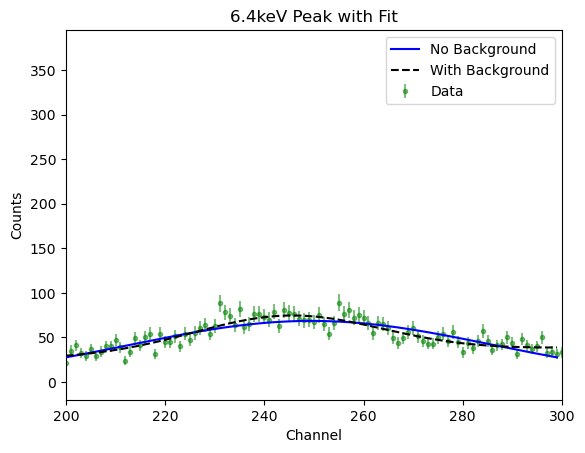

In [80]:
fig,ax = plt.subplots()
ax.errorbar(Calibration[0], Calibration[1], Calibration[2], fmt='g.',alpha = 0.5,label='Data')
ax.set_xlim(min_value,max_value)

channel2 = Calibration[0][min_value:max_value]
N2 = Calibration[1][min_value:max_value]
dN2 = Calibration[2][min_value:max_value]

p0 = [count_estimate, center_estimate , width_estimate]
channel_cont = np.linspace(min(channel2), max(channel2), 5000)
#ax.plot(channel_cont, gaussianfunc(p0, channel_cont), 'r--', label='Initial',zorder=10)

print("Gaussian only")
pf1, pferr1, chisq1, dof1 = data_fit(p0, gaussianfunc, channel2, N2, dN2)
ax.plot(channel_cont, gaussianfunc(pf1, channel_cont), 'b-', label='No Background',zorder=11)

print("\n\nGaussian with linear background")
p02 = [count_estimate, center_estimate , width_estimate,slope,offset]
pf2, pferr2, chisq2, dof2 = data_fit(p02, gaussianlinear, channel2, N2, dN2)
ax.plot(channel_cont, gaussianlinear(pf2, channel_cont), 'k--', label='With Background',zorder=11)
ax.set_xlabel("Channel")
ax.set_ylabel("Counts")
plt.title('6.4keV Peak with Fit')
ax.legend()

Data starts on row 22


Text(0.5, 1.0, 'Zn (25kV, 20$\\mu$A)')

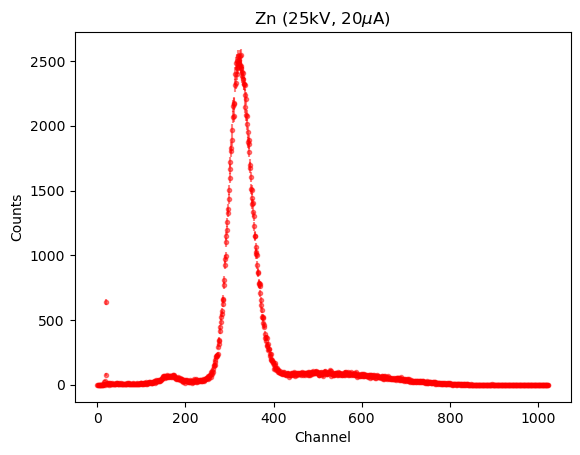

In [27]:
Zn=readfile("Flouresence/Zn.tsv")
fig,ax = plt.subplots()
ax.errorbar(Zn[0], Zn[1], Zn[2], fmt='r.',alpha = 0.5,label='Data')
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.title('Zn (25kV, 20$\mu$A)')

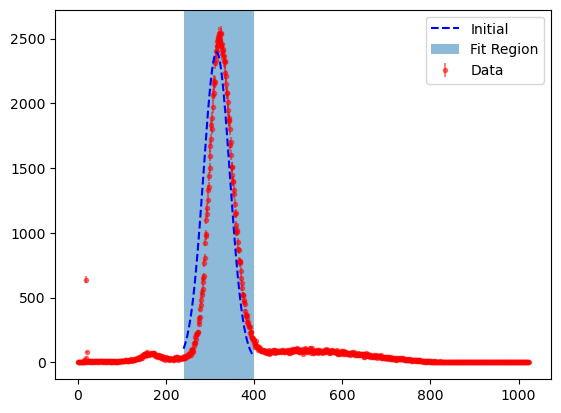

In [81]:
min_value = 240
max_value = 400
count_estimate = 180000
center_estimate = 315
width_estimate = 30
slope = 0
offset = 0
p02 = [count_estimate, center_estimate , width_estimate,slope,offset]


fig,ax = plt.subplots()
ax.errorbar(Zn[0], Zn[1], Zn[2], fmt='r.',alpha = 0.5,label='Data')
channel_cont = np.linspace(min_value, max_value , 5000)
ax.plot(channel_cont, gaussianlinear(p02, channel_cont), 'b--', label='Initial',zorder=10)
ax.axvspan(min_value ,max_value,label='Fit Region',alpha = 0.5)
ax.legend()

Gaussian only

Converged with chi-squared 1925.05
Number of degrees of freedom, dof = 157.00
Reduced chi-squared 12.26

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 1.800e+05                | 1.635e+05                | 4.054e+02               
1           | 3.150e+02                | 3.269e+02                | 6.901e-02               
2           | 3.000e+01                | 2.701e+01                | 5.387e-02               


Gaussian with linear background

Converged with chi-squared 652.54
Number of degrees of freedom, dof = 155.00
Reduced chi-squared 4.21

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 1.800e+05                | 1.478e+05                | 5.576e+02               
1           | 3.150e+02                | 3.251e+02                | 8.282e-02               
2           | 3.000e+01                | 2.454e+01               

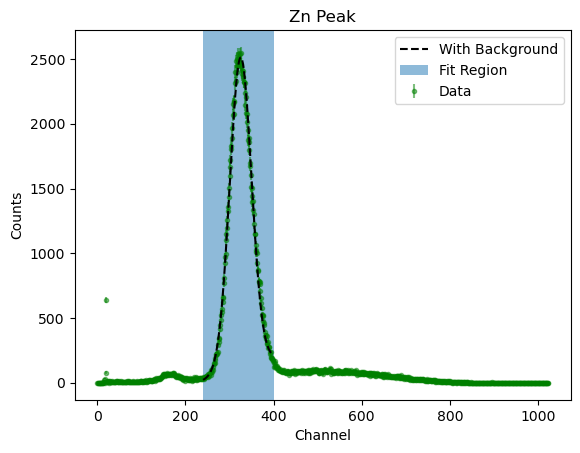

In [84]:
fig,ax = plt.subplots()
ax.errorbar(Zn[0], Zn[1], Zn[2], fmt='g.',alpha = 0.5,label='Data')
#ax.set_xlim(min_value,max_value)

channel2 = Zn[0][min_value:max_value]
N2 = Zn[1][min_value:max_value]
dN2 = Zn[2][min_value:max_value]

p0 = [count_estimate, center_estimate , width_estimate]
channel_cont = np.linspace(min(channel2), max(channel2), 5000)
#ax.plot(channel_cont, gaussianfunc(p0, channel_cont), 'r--', label='Initial',zorder=10)

print("Gaussian only")
pf1, pferr1, chisq1, dof1 = data_fit(p0, gaussianfunc, channel2, N2, dN2)
#ax.plot(channel_cont, gaussianfunc(pf1, channel_cont), 'b-', label='No Background',zorder=11)

print("\n\nGaussian with linear background")
p02 = [count_estimate, center_estimate , width_estimate,slope,offset]
pf2, pferr2, chisq2, dof2 = data_fit(p02, gaussianlinear, channel2, N2, dN2)
ax.plot(channel_cont, gaussianlinear(pf2, channel_cont), 'k--', label='With Background',zorder=11)
ax.axvspan(min_value ,max_value,label='Fit Region',alpha = 0.5)
ax.set_xlabel("Channel")
ax.set_ylabel("Counts")
plt.title('Zn Peak')
ax.legend()


Converged with chi-squared 0.35
Number of degrees of freedom, dof = 1.00
Reduced chi-squared 0.35

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | -3.660e-01               | 3.619e+01                | 5.476e-02               
1           | 2.700e-02                | 1.239e+01                | 5.002e-01               
[244.03084343 533.58109476 325.10491381]


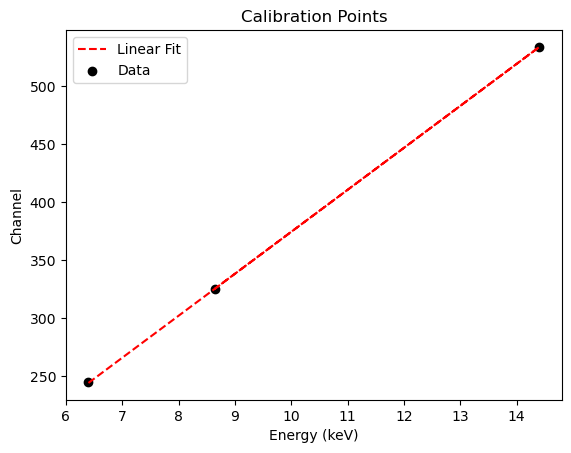

In [117]:
Cal_points_energy= np.array([6.4, 14.4, 8.64])#.reshape(-1, 1) 
Cal_points_channel=np.array([244.7, 533.6, 325.1])
Uncertainty=[1.139e+00, 3.070e-01, 8.282e-02]
p02=[-0.366, 0.027]

pf2, pferr2, chisq2, dof2 = data_fit(p02, linearfunc, Cal_points_energy, Cal_points_channel, Uncertainty)

fig,ax = plt.subplots()
plt.plot(Cal_points_energy, pf2[1] + (pf2[0])*Cal_points_energy, 'r--', label='Linear Fit')
plt.scatter(Cal_points_energy, Cal_points_channel, alpha = 1, c='k', label='Data')
ax.set_ylabel("Channel")
ax.set_xlabel("Energy (keV)")
ax.set_title('Calibration Points')

ax.legend()

print(pf2[1] + (pf2[0])*Cal_points_energy)

In [221]:
def convert(channel):
    energy= (channel - (12.36))/(36.14)
    return(energy)

def unconvert(energy):
    channel= (energy + (12.36))*(36.14)
    return(channel)

def uncertainty(channel, dc):
    #given channel and uncertainty in the channel will record total uncertainty in the measurement including calibration error
    #dy = np.sqrt((channel * 0.05476)**2  + (36.14 * dc)**2 + 0.5002**2)
    dy = np.sqrt((dc / 12.36)**2 + (0.05476 / 12.36)**2 + ((channel - 36.14) * 0.5002 / (12.36**2))**2)
    #uncertainty in energy given channel
    return(dy)

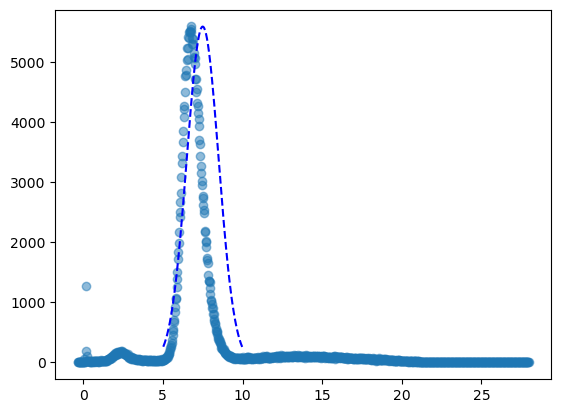

[5.02600996 5.05368013 5.0813503  5.10902048 5.13669065 5.16436082
 5.19203099 5.21970116 5.24737133 5.27504151 5.30271168 5.33038185
 5.35805202 5.38572219 5.41339236 5.44106253 5.46873271 5.49640288
 5.52407305 5.55174322 5.57941339 5.60708356 5.63475374 5.66242391
 5.69009408 5.71776425 5.74543442 5.77310459 5.80077476 5.82844494
 5.85611511 5.88378528 5.91145545 5.93912562 5.96679579 5.99446597
 6.02213614 6.04980631 6.07747648 6.10514665 6.13281682 6.160487
 6.18815717 6.21582734 6.24349751 6.27116768 6.29883785 6.32650802
 6.3541782  6.38184837 6.40951854 6.43718871 6.46485888 6.49252905
 6.52019923 6.5478694  6.57553957 6.60320974 6.63087991 6.65855008
 6.68622025 6.71389043 6.7415606  6.76923077 6.79690094 6.82457111
 6.85224128 6.87991146 6.90758163 6.9352518  6.96292197 6.99059214
 7.01826231 7.04593248 7.07360266 7.10127283 7.128943   7.15661317
 7.18428334 7.21195351 7.23962369 7.26729386 7.29496403 7.3226342
 7.35030437 7.37797454 7.40564471 7.43331489 7.46098506 7.4886552

In [152]:
min_value = 5
max_value = 10
count_estimate = 14000
center_estimate = 7.5
width_estimate = 1
slope = 0
offset = 0
p02 = [count_estimate, center_estimate , width_estimate,slope,offset]
energy=convert(Co[0])
channel2 = energy[(energy >= min_value) & (energy <= max_value)]
plt.scatter(energy, Co[1],alpha = 0.5,label='Data')
plt.plot(channel2, gaussianlinear(p02, channel2), 'b--', label='Initial',zorder=10)
plt.show()
print(channel2)

Data starts on row 22
Data starts on row 22
Data starts on row 22
Data starts on row 22
Data starts on row 22
Data starts on row 22
Data starts on row 22

Converged with chi-squared 44449.13
Number of degrees of freedom, dof = 1019.00
Reduced chi-squared 43.62

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 7.000e+03                | 8.090e+03                | 1.504e+01               
1           | 6.000e+00                | 6.878e+00                | 1.156e-03               
2           | 1.000e+00                | 6.026e-01                | 8.473e-04               
3           | 0.000e+00                | -7.266e-01               | 1.030e-02               
4           | 0.000e+00                | 2.051e+01                | 2.453e-01               


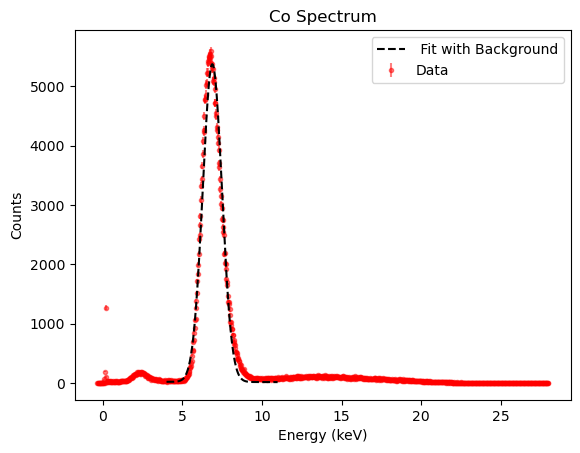


Converged with chi-squared 57780.35
Number of degrees of freedom, dof = 1019.00
Reduced chi-squared 56.70

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 7.000e+03                | 1.526e+03                | 6.604e+00               
1           | 6.000e+00                | 5.376e+00                | 2.176e-03               
2           | 1.000e+00                | 4.877e-01                | 1.679e-03               
3           | 0.000e+00                | -5.290e-01               | 8.953e-03               
4           | 0.000e+00                | 1.583e+01                | 2.096e-01               


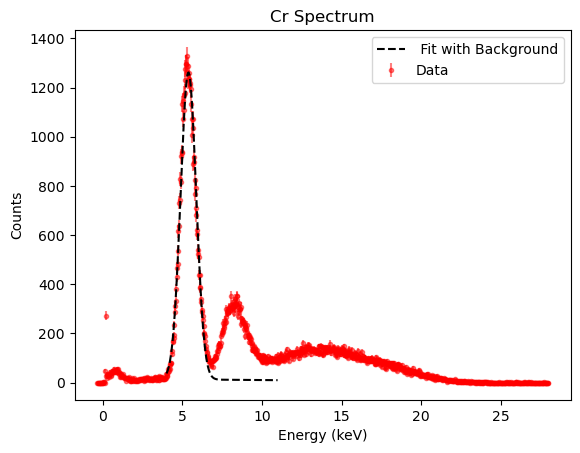


Converged with chi-squared 31927.67
Number of degrees of freedom, dof = 1019.00
Reduced chi-squared 31.33

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 7.000e+03                | 4.539e+03                | 1.127e+01               
1           | 6.000e+00                | 8.142e+00                | 1.716e-03               
2           | 1.000e+00                | 6.724e-01                | 1.279e-03               
3           | 0.000e+00                | -4.258e-01               | 8.427e-03               
4           | 0.000e+00                | 1.299e+01                | 1.952e-01               


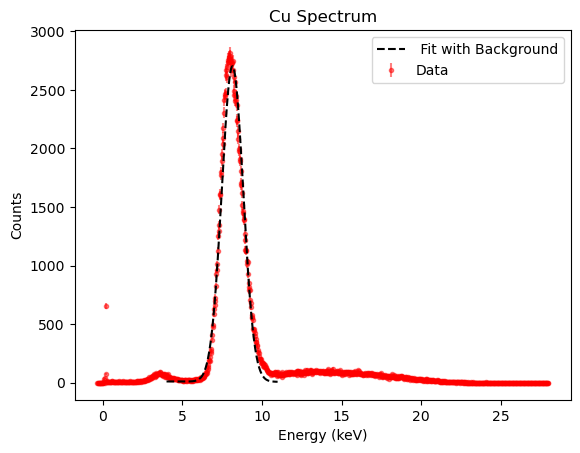


Converged with chi-squared 46176.86
Number of degrees of freedom, dof = 1019.00
Reduced chi-squared 45.32

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 7.000e+03                | 6.621e+03                | 1.362e+01               
1           | 6.000e+00                | 6.328e+00                | 1.192e-03               
2           | 1.000e+00                | 5.614e-01                | 8.840e-04               
3           | 0.000e+00                | -7.480e-01               | 1.035e-02               
4           | 0.000e+00                | 2.103e+01                | 2.466e-01               


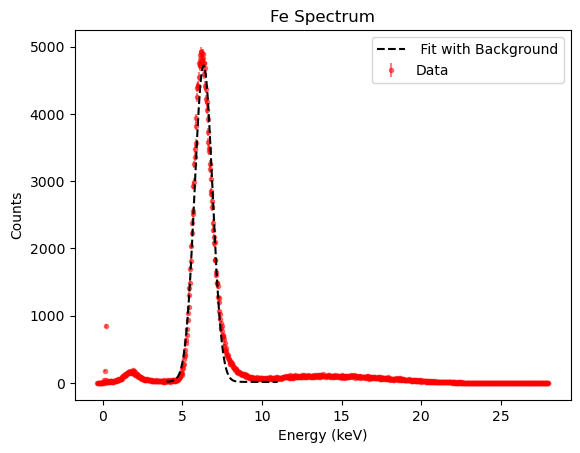


Converged with chi-squared 53596.65
Number of degrees of freedom, dof = 1019.00
Reduced chi-squared 52.60

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 7.000e+03                | 2.416e+03                | 8.280e+00               
1           | 6.000e+00                | 5.880e+00                | 1.874e-03               
2           | 1.000e+00                | 5.282e-01                | 1.439e-03               
3           | 0.000e+00                | -6.134e-01               | 9.489e-03               
4           | 0.000e+00                | 1.795e+01                | 2.245e-01               


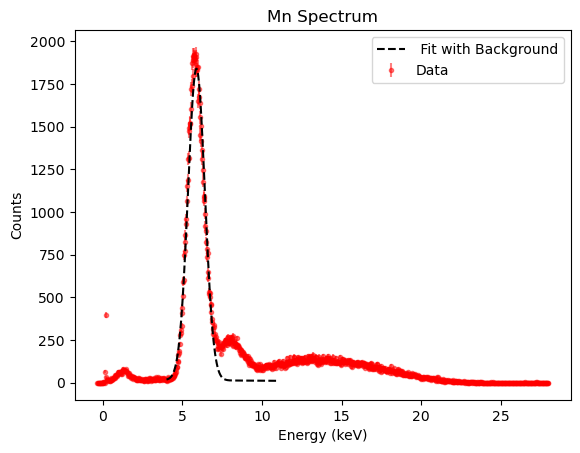


Converged with chi-squared 32756.81
Number of degrees of freedom, dof = 1019.00
Reduced chi-squared 32.15

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 7.000e+03                | 4.889e+03                | 1.170e+01               
1           | 6.000e+00                | 7.559e+00                | 1.615e-03               
2           | 1.000e+00                | 6.565e-01                | 1.200e-03               
3           | 0.000e+00                | -4.786e-01               | 8.833e-03               
4           | 0.000e+00                | 1.418e+01                | 2.056e-01               


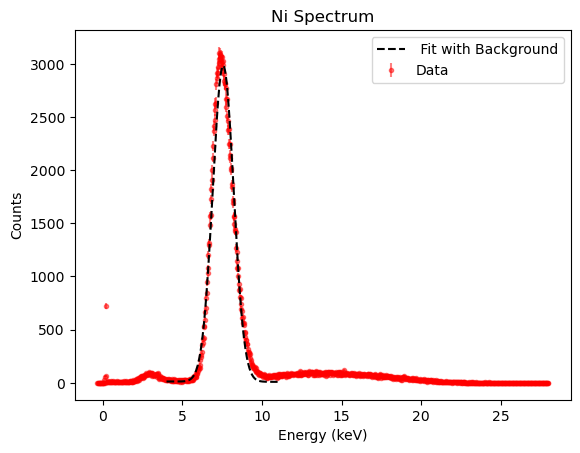


Converged with chi-squared 45242.29
Number of degrees of freedom, dof = 1019.00
Reduced chi-squared 44.40

Parameter # | Initial guess values:    | Best fit values:         | Uncertainties in the best fit values:
0           | 7.000e+03                | 2.342e+03                | 8.138e+00               
1           | 6.000e+00                | 4.888e+00                | 1.626e-03               
2           | 1.000e+00                | 4.566e-01                | 1.226e-03               
3           | 0.000e+00                | -5.643e-01               | 9.135e-03               
4           | 0.000e+00                | 1.653e+01                | 2.142e-01               


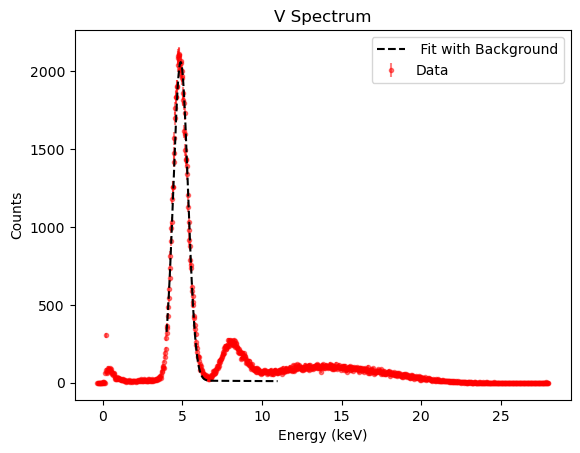

In [225]:
#FLOURESENCE 
Co= readfile("flouresence/Co.tsv")
Cr= readfile("flouresence/Cr.tsv")
Cu= readfile("flouresence/Cu.tsv")
Fe= readfile("flouresence/Fe.tsv")
Mn= readfile("flouresence/Mn.tsv")
Ni= readfile("flouresence/Ni.tsv")
V= readfile("flouresence/V.tsv")

energies=[]
uncert=[]
for i, t in zip([Co, Cr, Cu, Fe, Mn, Ni, V], ['Co', 'Cr', 'Cu', 'Fe', 'Mn', 'Ni', 'V']):

    min_value = 4
    max_value = 11
    count_estimate = 7000
    center_estimate = 6
    width_estimate = 1
    slope = 0
    offset = 0
    p02 = [count_estimate, center_estimate , width_estimate,slope,offset]
    energy=convert(i[0])
    pf2, pferr2, chisq2, dof2 = data_fit(p02, gaussianlinear, energy, i[1], i[2])

    channel2 = energy[min_value:max_value]
    N2 = i[1][min_value:max_value]
    dN2 = i[2][min_value:max_value]
    channel2 = energy[(energy >= min_value) & (energy <= max_value)]
    fig,ax = plt.subplots()
    ax.errorbar(energy, i[1], i[2], fmt='r.',alpha = 0.5,label='Data')
    #ax.plot(channel2, gaussianlinear(p02, channel2), 'b--', label='Initial',zorder=10)
    ax.plot(channel2, gaussianlinear(pf2, channel2), 'k--', label=' Fit with Background',zorder=11)
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.title(t + ' Spectrum')
    plt.legend()
    plt.savefig(t +'.png')
    plt.show()
    uncert.append(uncertainty(unconvert(pf2[1]), unconvert(pferr2[1]))-36)
    energies.append(pf2[1])



In [223]:
print(uncert)


[36.207749358751485, 36.200571870628416, 36.21860851567411, 36.20403413318793, 36.203001989363536, 36.21398697264281, 36.195851206908046]


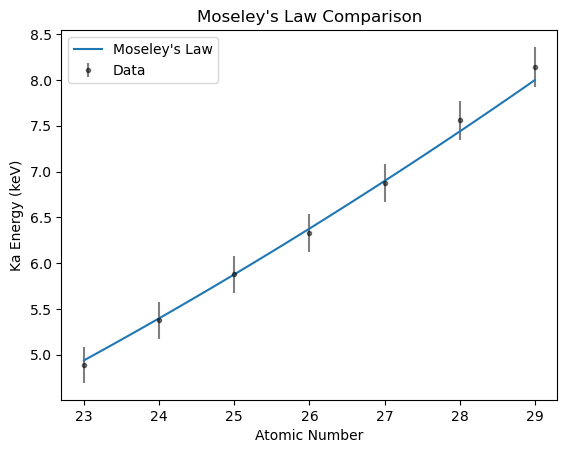

In [264]:
#Moseleys Law
R=10973731.6
h=4.135e-15
c=299792458
Z=np.linspace(23, 29, 100)
atom=[27, 24, 29, 26, 25, 28, 23]

fig,ax = plt.subplots()
ax.errorbar(atom, energies, uncert, fmt='k.',alpha = 0.5,label='Data')
plt.plot(Z, c*h*R*0.75*((Z-1)**2)/1000, label= "Moseley's Law")
plt.xlabel('Atomic Number')
plt.ylabel('Ka Energy (keV)')
plt.title("Moseley's Law Comparison")
plt.legend()
plt.show() 

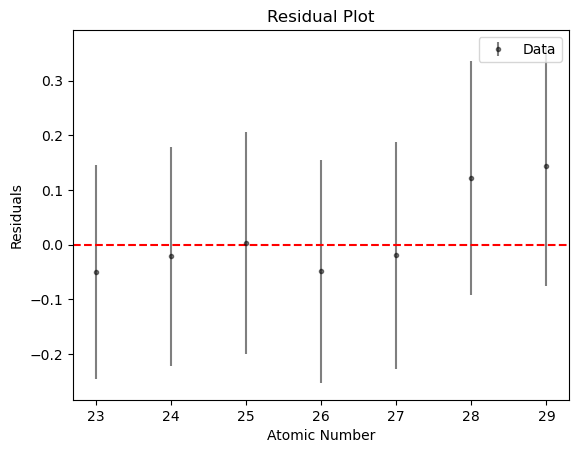

In [271]:
residual=[]
for Z in range(len(atom)):
    residual.append(energies[Z]-c*h*R*0.75*((atom[Z]-1)**2)/1000)
fig,ax = plt.subplots()
ax.errorbar(atom, residual, uncert, fmt='k.',alpha = 0.5,label='Data')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Atomic Number")
plt.ylabel("Residuals")
plt.title('Residual Plot')
plt.legend()

In [229]:
#Transmission

angle=np.array([35
,36
,37
,38
,39
,40
,40.5
,41
,41.5
,42
,42.5
,43
,43.5
,44
,44.5
,45
,46
,47
,48
,49
,50
,51])

ro=np.array([1735
,1886
,2423
,1446
,2167
,20860
,19622
,2607
,2088
,2186
,1939
,1884
,2193
,11698
,86843
,10582
,1684
,1333
,1346
,1092
,912
,827])

ra=np.array([53
,44
,52
,35
,40
,112
,153
,29
,31
,30
,51
,235
,802
,3873
,29455
,3346
,527
,399
,412
,345
,267
,229])

Text(0.5, 1.0, 'Transmission')

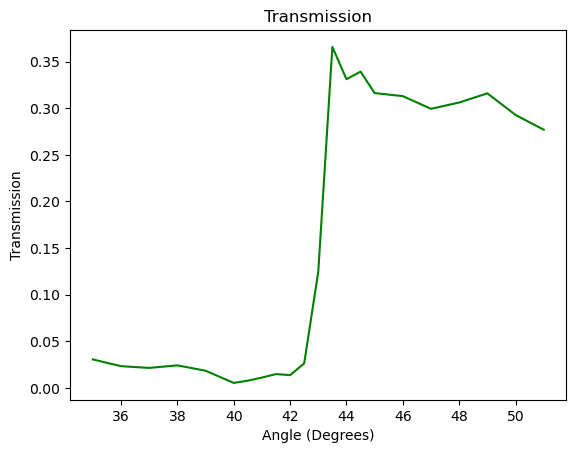

In [349]:
plt.plot(angle, ra/ro, c='g')
#plt.scatter(angle, ra/ro, c='b')
plt.xlabel('Angle (Degrees)')
plt.ylabel('Transmission')
plt.title('Transmission')

In [258]:
max(ra)
Calibration[0][5:1024]

array([   5.,    6.,    7., ..., 1021., 1022., 1023.])

Data starts on row 22


Text(0.5, 1.0, '37 Degrees (25kV, 20$\\mu$A)')

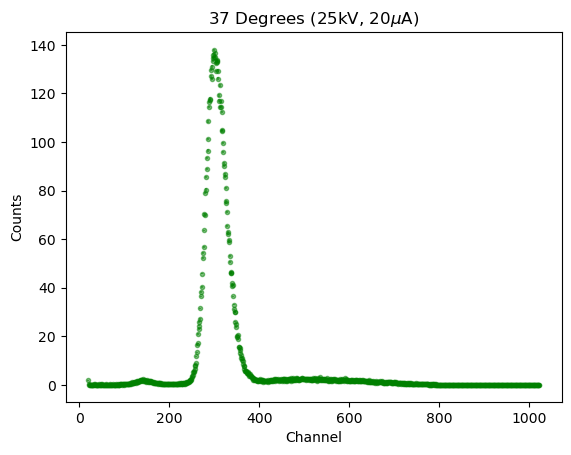

In [262]:
Calibration= readfile("flouresence/Cu.tsv")
Calibration[1]=Calibration[1][20:1024]
fig,ax = plt.subplots()
ax.errorbar(Calibration[0][20:1024], ((Calibration[1]**1.2)*0.01), Calibration[2][20:1024]*0.01, fmt='g.',alpha = 0.5,label='Data')
plt.xlabel('Channel')
plt.ylabel('Counts')
plt.title('37 Degrees (25kV, 20$\mu$A)')